#### LSTM Model for Limit Order Book 


#### 1: Use DataLoader class to create training and dev data sets from zipped files stored in data folder.

#### 2: Build and compile model using model class based on configuration in config file.

#### 3: Use GenerateBatch class to create itereator to feed batches of sequences of x and y train/val data into model

#### 4: Train model using train_generator method from model class

#### 5: Plot train loss vs val loss

#### 6: Make training and validation predictions using same sequence lengths and batch sizes

#### 7: Compute Precision/Recall/F1 statistics and Cohen Kappa


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time
import json
%matplotlib inline
# 
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [2]:
import os; 
#work-around to allow import from directory on same level
os.sys.path.append(os.path.dirname(os.path.abspath('.')))
from input.DataLoader import DataLoader
from input.GenerateBatch import GenerateBatch
from model.Model import Model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Dropout
from keras.utils import to_categorical
from keras.metrics import categorical_crossentropy
from sklearn.metrics import accuracy_score
from scipy.stats import linregress
from sklearn.utils import shuffle

In [4]:
# recover training and test data from zip files. Provide list of days for each
traindays=[0,1,2] 
valdays=[3]

path='data/'
d=DataLoader(path)
traindf=d.get_days(traindays)
valdf=d.get_days(valdays)

# Select X and Y training and dev data. Y is categorical
trainx=traindf.iloc[:,range(40)].values
trainy=to_categorical(traindf.iloc[:,148].values-1)
valx=valdf.iloc[:,range(40)].values
valy=to_categorical(valdf.iloc[:,148].values-1)


In [5]:
print(trainx.shape)
print(trainy.shape)

(106444, 40)
(106444, 3)


In [6]:
configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])
print('training',configs['training'])
print('model loss:',configs['model']['loss'])
print('model optimizer:',configs['model']['optimizer'])
print('save dir:',configs['model']['save_dir'])
for i,j in enumerate(configs['model']['layers']):
    print('layer %i' %i)
    print(j)

training {'sequence_length': 5, 'epochs': 10, 'batch_size': 25}
model loss: categorical_crossentropy
model optimizer: adam
save dir: saved_models
layer 0
{'type': 'lstm', 'neurons': 50, 'input_timesteps': 5, 'input_dim': 40, 'return_seq': False}
layer 1
{'type': 'dropout', 'rate': 0.2}
layer 2
{'type': 'dense', 'neurons': 3, 'activation': 'softmax'}


In [7]:
model = Model()
model.build_model(configs)

model.model.summary()

[Model] Model Compiled
Time taken: 0:00:00.221389
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 18,353
Trainable params: 18,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
training_generator=GenerateBatch(trainx,trainy)
#training_generator.GenerateBatch(configs['training']['sequence_length'],configs['training']['batch_size'])
#using same sequence length and batch size for val data 
val_generator=GenerateBatch(valx,valy)
#val_generator.GenerateBatch(configs['training']['sequence_length'],configs['training']['batch_size'])

In [9]:
# out-of memory generative training
#steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
steps_per_epoch =int((trainx.shape[0]-configs['training']['sequence_length'])/configs['training']['batch_size'])
print(steps_per_epoch)
steps_per_epoch_val=int((valx.shape[0]-configs['training']['sequence_length'])/configs['training']['batch_size'])
print(steps_per_epoch,steps_per_epoch_val)

4257
4257 1480


In [10]:
history=model.train_generator(
    train_gen=training_generator.GenerateBatch(configs['training']['sequence_length'],
                                               configs['training']['batch_size']),
    val_gen=val_generator.GenerateBatch(configs['training']['sequence_length'],
                                        configs['training']['batch_size']),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    save_dir=configs['model']['save_dir']
    )

    

[Model] Training Started
[Model] 10 epochs, 25 batch size, 4257 batches per epoch
Epoch 1/10
 - 25s - loss: 1.0437 - val_loss: 1.0377
Epoch 2/10
 - 24s - loss: 1.0177 - val_loss: 1.0253
Epoch 3/10
 - 24s - loss: 1.0060 - val_loss: 1.0197
Epoch 4/10
 - 24s - loss: 0.9937 - val_loss: 1.0118
Epoch 5/10
 - 24s - loss: 0.9834 - val_loss: 1.0112
Epoch 6/10
 - 24s - loss: 0.9712 - val_loss: 1.0140
Epoch 7/10
 - 24s - loss: 0.9613 - val_loss: 1.0164
Epoch 8/10
 - 25s - loss: 0.9525 - val_loss: 1.0151
Epoch 9/10
 - 25s - loss: 0.9451 - val_loss: 1.0102
Epoch 10/10
 - 25s - loss: 0.9359 - val_loss: 1.0113
[Model] Training Completed. Model saved as saved_models/09112018-132550-e10.h5
Time taken: 0:04:07.094628


Text(0,0.5,'Cost')

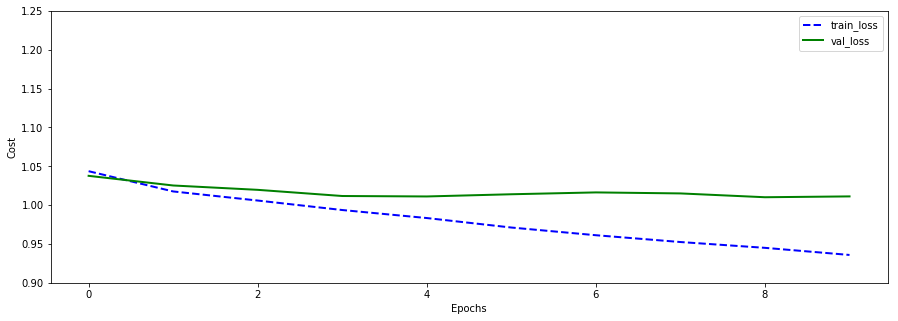

In [11]:

plt.figure(figsize=(15,5))
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
plt.ylim([.9,1.25])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [68]:
# make our predictions - start from beginning
train_gen=training_generator.GenerateBatch(configs['training']['sequence_length'],configs['training']['batch_size'])
val_gen=val_generator.GenerateBatch(configs['training']['sequence_length'],configs['training']['batch_size'])

In [69]:
y_train=[]
yhat_train=[]
y_val=[]
yhat_val=[]

In [70]:
# predict using same sequence lengths and batches as in training
for i in range(steps_per_epoch):
    dat=next(train_gen)
    y_train.append(dat[1])
    yhat_train.append(model.model.predict(dat[0]))
for i in range(steps_per_epoch_val):
    dat=next(val_gen)
    y_val.append(dat[1])
    yhat_val.append(model.model.predict(dat[0]))
                                            

In [71]:
y_train=np.array(y_train).reshape(-1,3)
yhat_train=np.array(yhat_train).reshape(-1,3)
y_val=np.array(y_val).reshape(-1,3)
yhat_val=np.array(yhat_val).reshape(-1,3)


In [74]:
# How well have we done on training data
print ("Training ")
Y=np.argmax(y_train,axis=1)
Yhat=np.argmax(yhat_train,axis=1)
c=confusion_matrix(Y,Yhat)
c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
print(c)
print(classification_report(Yhat,Y))
print("cohen kappa score:",cohen_kappa_score(Yhat,Y))
# How well have we done on test data
print("Test ")
Y=np.argmax(y_val,axis=1)
Yhat=np.argmax(yhat_val,axis=1)
c=confusion_matrix(Y,Yhat)
c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
print(c)
print(classification_report(Yhat,Y))
print("cohen kappa score:",cohen_kappa_score(Yhat,Y))

Training 
[[ 31457   1834   9890  43181]
 [ 12847   5614   3919  22380]
 [ 23409   1456  15999  40864]
 [ 67713   8904  29808 106425]]
             precision    recall  f1-score   support

          0       0.73      0.46      0.57     67713
          1       0.25      0.63      0.36      8904
          2       0.39      0.54      0.45     29808

avg / total       0.59      0.50      0.52    106425

cohen kappa score: 0.18707377734414887
Test 
[[ 9597   890  4449 14936]
 [ 3875   764  2088  6727]
 [ 7435   828  7074 15337]
 [20907  2482 13611 37000]]
             precision    recall  f1-score   support

          0       0.64      0.46      0.54     20907
          1       0.11      0.31      0.17      2482
          2       0.46      0.52      0.49     13611

avg / total       0.54      0.47      0.49     37000

cohen kappa score: 0.12917322249804797
